In [1]:
import datetime
import matplotlib.pyplot as plt
import numpy as np
import warnings
import os
import pandas as pd
import pickle
import seaborn as sns

%matplotlib inline
sns.set(color_codes=True)

# set the maximun number of columns to display
pd.set_option('display.max_columns' , 100)

# ignore the warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
PICKLE_ENERGY_DIR = os.path.join("processed_data", "processed_EnergyData.pkl")
PICKLE_PRICE_DIR = os.path.join("processed_data", "processed_PriceData.pkl")

pco_energydata = pd.read_pickle(PICKLE_ENERGY_DIR) 
pco_history = pd.read_pickle(PICKLE_PRICE_DIR)

# Feature Engineering 
### Mean Off peak prices in December and January.

off peak mean prices in december and january

In [3]:
pco_energydata.columns

Index(['id', 'channel_sales', 'date_activ', 'date_end', 'date_modif_prod',
       'date_renewal', 'forecast_discount_energy', 'forecast_price_energy_p1',
       'forecast_price_energy_p2', 'forecast_price_pow_p1', 'has_gas',
       'margin_gross_pow_ele', 'margin_net_pow_ele', 'nb_prod_act',
       'net_margin', 'num_years_antig', 'origin_up', 'pow_max', 'churn',
       'mean_year_price_p1_var', 'mean_year_price_p2_var',
       'mean_year_price_p3_var', 'mean_year_price_p1_fix',
       'mean_year_price_p2_fix', 'mean_year_price_p3_fix',
       'mean_year_price_p1', 'mean_year_price_p2', 'mean_year_price_p3',
       'mean_6m_price_p1_var', 'mean_6m_price_p2_var', 'mean_6m_price_p3_var',
       'mean_6m_price_p1_fix', 'mean_6m_price_p2_fix', 'mean_6m_price_p3_fix',
       'mean_6m_price_p1', 'mean_6m_price_p2', 'mean_6m_price_p3',
       'mean_3m_price_p1_var', 'mean_3m_price_p2_var', 'mean_3m_price_p3_var',
       'mean_3m_price_p1_fix', 'mean_3m_price_p2_fix', 'mean_3m_price_p3_fix',
 

In [4]:
# group by prices and id
monthly_price_id = pco_history.groupby(['id' , 'price_date']).agg({
    'price_p1_var' : 'mean',
    'price_p1_fix' : 'mean'
}).reset_index()

jan_prices = monthly_price_id.groupby('id').first().reset_index()
dec_prices = monthly_price_id.groupby('id').last().reset_index()

diff = pd.merge(dec_prices.rename(columns={
    'price_p1_var' : 'dec_1',
    'price_p1_fix' : 'dec_2'
}) , jan_prices.drop(columns='price_date') , on='id')

diff['p1_diff_dec_jan_energy'] = diff['dec_1'] - diff['price_p1_var']
diff['p1_diff_dec_power'] = diff['dec_2'] - diff['price_p1_fix']
diff = diff[['id' , 'p1_diff_dec_jan_energy' , 'p1_diff_dec_power']]

In [5]:
pco_energydata = pd.merge(pco_energydata , diff , on='id')
pco_energydata.columns

Index(['id', 'channel_sales', 'date_activ', 'date_end', 'date_modif_prod',
       'date_renewal', 'forecast_discount_energy', 'forecast_price_energy_p1',
       'forecast_price_energy_p2', 'forecast_price_pow_p1', 'has_gas',
       'margin_gross_pow_ele', 'margin_net_pow_ele', 'nb_prod_act',
       'net_margin', 'num_years_antig', 'origin_up', 'pow_max', 'churn',
       'mean_year_price_p1_var', 'mean_year_price_p2_var',
       'mean_year_price_p3_var', 'mean_year_price_p1_fix',
       'mean_year_price_p2_fix', 'mean_year_price_p3_fix',
       'mean_year_price_p1', 'mean_year_price_p2', 'mean_year_price_p3',
       'mean_6m_price_p1_var', 'mean_6m_price_p2_var', 'mean_6m_price_p3_var',
       'mean_6m_price_p1_fix', 'mean_6m_price_p2_fix', 'mean_6m_price_p3_fix',
       'mean_6m_price_p1', 'mean_6m_price_p2', 'mean_6m_price_p3',
       'mean_3m_price_p1_var', 'mean_3m_price_p2_var', 'mean_3m_price_p3_var',
       'mean_3m_price_p1_fix', 'mean_3m_price_p2_fix', 'mean_3m_price_p3_fix',
 

### Average Off peak prices in December and January.
off peak average prices in december and january

In [6]:
mean_prices = pco_history.groupby(['id']).agg({
    'price_p1_var' : 'mean',
    'price_p2_var' : 'mean',
    'price_p3_var' : 'mean',
    'price_p1_fix' : 'mean' , 
    'price_p2_fix' : 'mean' , 
    'price_p3_fix' : 'mean'
}).reset_index()

In [7]:
mean_prices.columns

Index(['id', 'price_p1_var', 'price_p2_var', 'price_p3_var', 'price_p1_fix',
       'price_p2_fix', 'price_p3_fix'],
      dtype='object')

In [8]:
# Calculate the mean difference between consecutive periods
mean_prices['p1_p2_mean_diff'] = mean_prices['price_p1_var'] - mean_prices['price_p2_var']
mean_prices['p2_p3_mean_diff'] = mean_prices['price_p2_var'] - mean_prices['price_p3_var']
mean_prices['p1_p3_mean_diff'] = mean_prices['price_p1_var'] - mean_prices['price_p3_var']
mean_prices['p1_p2_mean_diff'] = mean_prices['price_p1_fix'] - mean_prices['price_p2_fix']
mean_prices['p2_p3_mean_diff'] = mean_prices['price_p2_fix'] - mean_prices['price_p3_fix']
mean_prices['p1_p3_mean_diff'] = mean_prices['price_p1_fix'] - mean_prices['price_p3_fix']

In [9]:
columns = [
    'id', 
    'p1_p2_mean_diff',
    'p2_p3_mean_diff', 
    'p1_p3_mean_diff',
    'p1_p2_mean_diff', 
    'p2_p3_mean_diff', 
    'p1_p3_mean_diff'
]
pco_energydata = pd.merge(pco_energydata, mean_prices[columns], on='id')
pco_energydata.shape

(15673, 61)

This will be add more granularity to the existing. We have now created features that look at mean average price differences across different time periods (`off_peak`, `peak`, `mid_peak`). The dec-jan feature may reveal macro patterns that occur over an entire year, whereas inter-time-period features may reveal patterns on a micro scale between months.

### Max price across the period and months.
Another way we can enhance the feature from our colleague is to look at the maximum change in prices across periods and months.

In [10]:
# Aggregate average prices per period by company
mean_prices_by_month = pco_history.groupby(['id', 'price_date']).agg({
    'price_p1_var': 'mean', 
    'price_p2_var': 'mean', 
    'price_p3_var': 'mean',
    'price_p1_fix': 'mean',
    'price_p2_fix': 'mean',
    'price_p3_fix': 'mean'    
}).reset_index()

In [11]:
# Calculate the mean difference between consecutive periods
mean_prices_by_month['off_peak_peak_var_mean_diff'] = mean_prices_by_month['price_p1_var'] - mean_prices_by_month['price_p2_var']
mean_prices_by_month['peak_mid_peak_var_mean_diff'] = mean_prices_by_month['price_p2_var'] - mean_prices_by_month['price_p3_var']
mean_prices_by_month['off_peak_mid_peak_var_mean_diff'] = mean_prices_by_month['price_p1_var'] - mean_prices_by_month['price_p3_var']
mean_prices_by_month['off_peak_peak_fix_mean_diff'] = mean_prices_by_month['price_p1_fix'] - mean_prices_by_month['price_p2_var']
mean_prices_by_month['peak_mid_peak_fix_mean_diff'] = mean_prices_by_month['price_p2_fix'] - mean_prices_by_month['price_p3_fix']
mean_prices_by_month['off_peak_mid_peak_fix_mean_diff'] = mean_prices_by_month['price_p1_fix'] - mean_prices_by_month['price_p3_fix']

In [12]:
# Calculate the maximum monthly difference across time periods
max_diff_across_periods_months = mean_prices_by_month.groupby(['id']).agg({
    'off_peak_peak_var_mean_diff': 'max',
    'peak_mid_peak_var_mean_diff': 'max',
    'off_peak_mid_peak_var_mean_diff': 'max',
    'off_peak_peak_fix_mean_diff': 'max',
    'peak_mid_peak_fix_mean_diff': 'max',
    'off_peak_mid_peak_fix_mean_diff': 'max'
}).reset_index().rename(
    columns={
        'off_peak_peak_var_mean_diff': 'p1_p2_max_monthly_diff',
        'peak_mid_peak_var_mean_diff': 'p2_p3_max_monthly_diff',
        'off_peak_mid_peak_var_mean_diff': 'p1_p3_max_monthly_diff',
        'off_peak_peak_fix_mean_diff': 'p1_p2_fix_max_monthly_diff',
        'peak_mid_peak_fix_mean_diff': 'p2_p3_fix_max_monthly_diff',
        'off_peak_mid_peak_fix_mean_diff': 'p1_p3_fix_max_monthly_diff'
    }
)

In [13]:
columns = [
    'id',
    'p1_p2_max_monthly_diff',
    'p2_p3_max_monthly_diff',
    'p1_p3_max_monthly_diff',
    'p1_p2_fix_max_monthly_diff',
    'p2_p3_fix_max_monthly_diff',
    'p1_p3_fix_max_monthly_diff'
]

pco_energydata = pd.merge(pco_energydata, max_diff_across_periods_months[columns], on='id')
pco_energydata.columns

Index(['id', 'channel_sales', 'date_activ', 'date_end', 'date_modif_prod',
       'date_renewal', 'forecast_discount_energy', 'forecast_price_energy_p1',
       'forecast_price_energy_p2', 'forecast_price_pow_p1', 'has_gas',
       'margin_gross_pow_ele', 'margin_net_pow_ele', 'nb_prod_act',
       'net_margin', 'num_years_antig', 'origin_up', 'pow_max', 'churn',
       'mean_year_price_p1_var', 'mean_year_price_p2_var',
       'mean_year_price_p3_var', 'mean_year_price_p1_fix',
       'mean_year_price_p2_fix', 'mean_year_price_p3_fix',
       'mean_year_price_p1', 'mean_year_price_p2', 'mean_year_price_p3',
       'mean_6m_price_p1_var', 'mean_6m_price_p2_var', 'mean_6m_price_p3_var',
       'mean_6m_price_p1_fix', 'mean_6m_price_p2_fix', 'mean_6m_price_p3_fix',
       'mean_6m_price_p1', 'mean_6m_price_p2', 'mean_6m_price_p3',
       'mean_3m_price_p1_var', 'mean_3m_price_p2_var', 'mean_3m_price_p3_var',
       'mean_3m_price_p1_fix', 'mean_3m_price_p2_fix', 'mean_3m_price_p3_fix',
 

The maximum price change between months and time periods would be a good feature to create because I was trying to think from the perspective of a PowerCo client

## Tenure
How long a company has been a client of PowerCo.

In [14]:
pco_energydata['tenure'] = ((pco_energydata['date_end'] - pco_energydata['date_activ']) / np.timedelta64(1,'Y')).astype(int)

In [15]:
pco_energydata.groupby(['tenure']).agg({
    'churn' : 'mean'
}).sort_values(by='churn' , ascending=False)

,churn
tenure,
3,0.139262
2,0.132653
4,0.125398
12,0.090323
5,0.087104
13,0.085106
6,0.080990
11,0.077626
7,0.072413


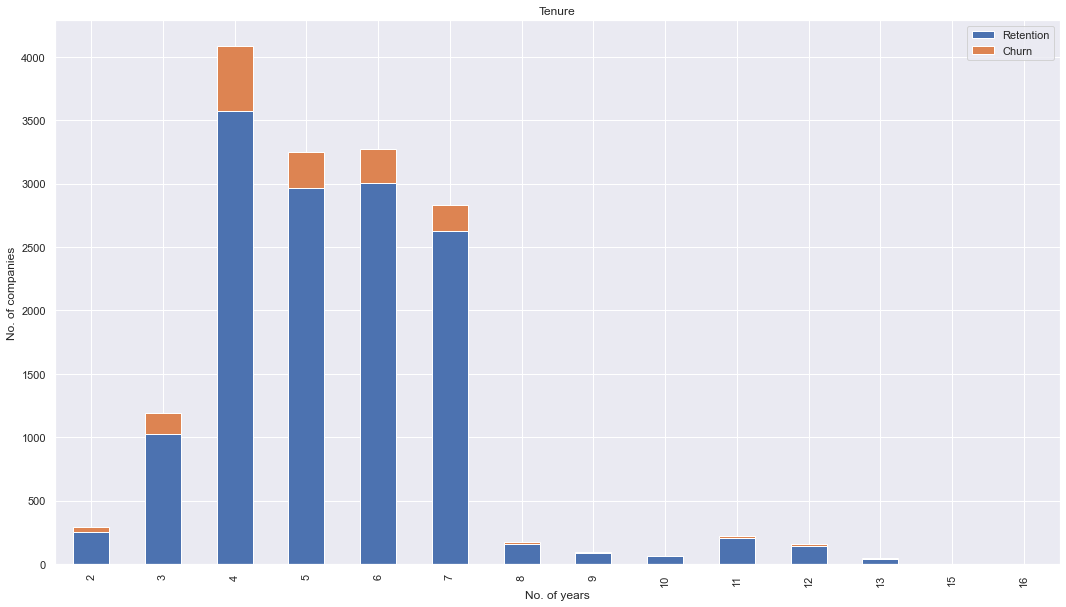

In [16]:
# print in the graph form
tenure_count = pco_energydata.groupby(['tenure','churn' ])['churn'].count().unstack(level=1)

# bar graph
tenure_count.plot(kind="bar", figsize=(18,10), stacked=True, title= "Tenure")

# Rename legend
plt.legend(["Retention", "Churn"], loc="upper right")
# Labels
plt.ylabel("No. of companies") 
plt.xlabel("No. of years")
plt.show()


The companies who have only been a client for 4 or less months are much more likely to churn compared to companies that have been a client for longer. Interestingly, the difference between 4 and 5 months is about 4%, which represents a large jump in likelihood for a customer to churn compared to the other differences between ordered tenure values. Perhaps this reveals that getting a customer to over 4 months tenure is actually a large milestone with respect to keeping them as a long term customer. 

This is an interesting feature to keep for modelling because clearly how long you've been a client, has a influence on the chance of a client churning.

In [17]:
from datetime import datetime

def convert_months(data , column):
    
    ref_date = datetime(2016 , 1, 1)
    delta = ref_date - data[column]
    months = (delta / np.timedelta64(1 , 'M')).astype(int)
    return months

In [18]:
pco_energydata['time_since_months_activ'] = convert_months(pco_energydata , 'date_activ')
pco_energydata['time_since_months_to_end'] = -convert_months(pco_energydata, 'date_end')
pco_energydata['time_since_months_modif_prod'] = convert_months(pco_energydata, 'date_modif_prod')
pco_energydata['time_since_months_renewal'] = convert_months(pco_energydata, 'date_renewal')

In [19]:
def plot_monthly_churn(pco_df, column):
    
    temp = pco_df.groupby([column , 'churn'])['churn'].count().unstack(level=1)
    temp.plot(kind="bar", figsize=(18,10), stacked=True, rot=0, title= column)
    # Rename legend
    plt.legend(["Retention", "Churn"], loc="upper right")
    # Labels
    plt.ylabel("Number of Contracts") 
    plt.xlabel("No. of months")
    # Set xlabel fontsize
    plt.xticks(fontsize=7) 
    plt.show()


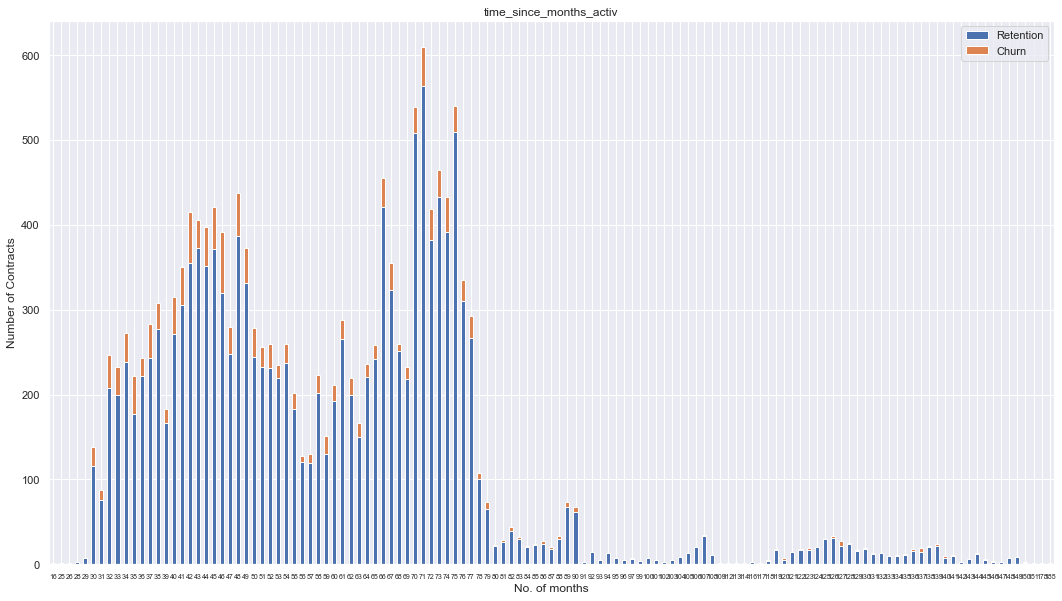

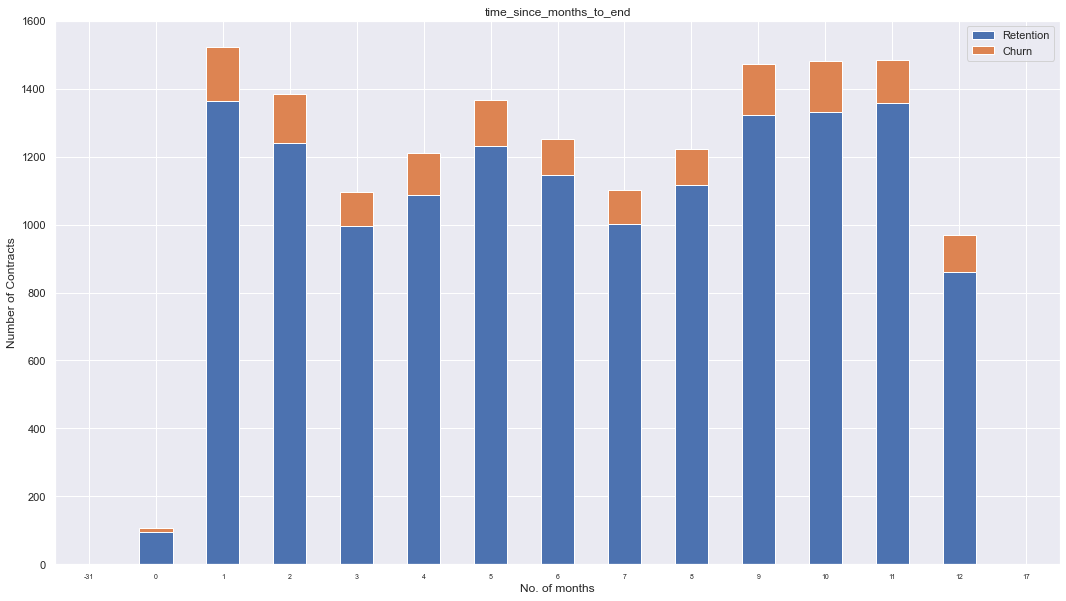

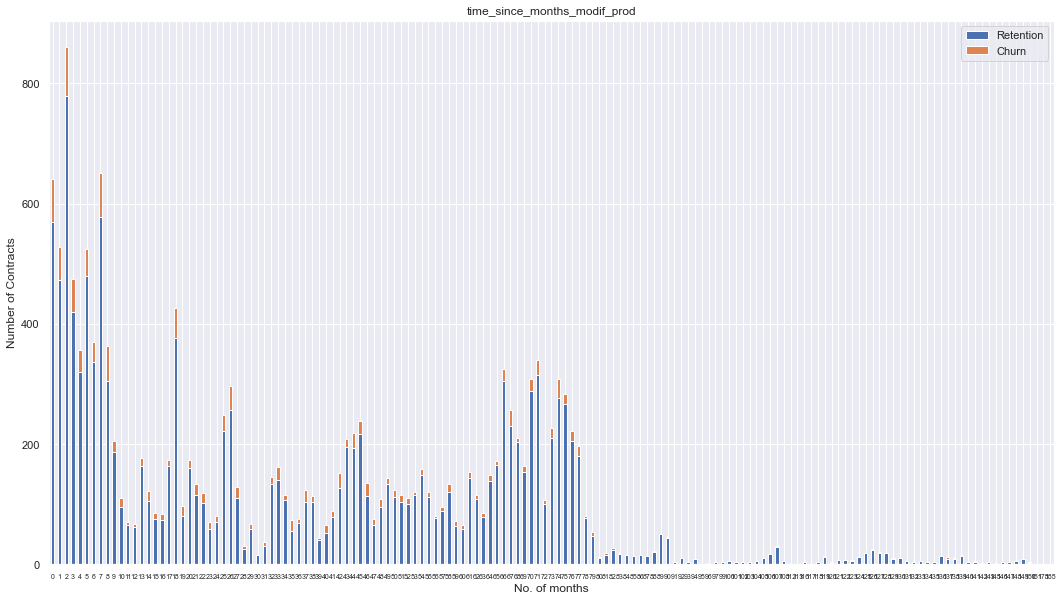

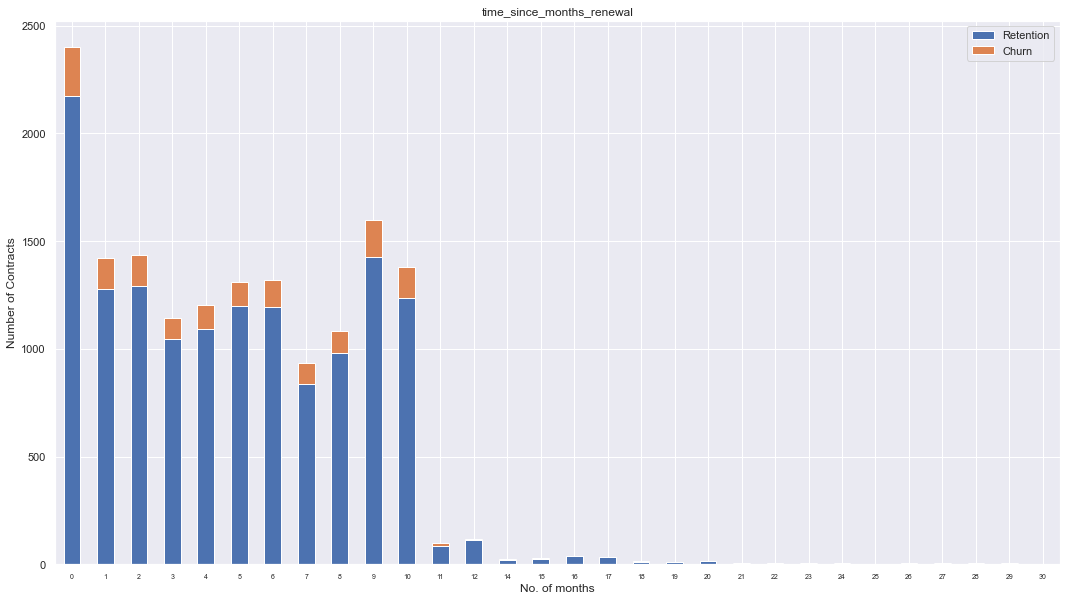

In [20]:
columns = ['time_since_months_activ' , 'time_since_months_to_end' , 'time_since_months_modif_prod' , 'time_since_months_renewal']
for cols in columns:
    plot_monthly_churn(pco_energydata , cols)

If we think from the perspective of a client with PowerCo, if you're coming toward the end of your contract with PowerCo your thoughts could go a few ways. You could be looking for better deals for when your contract ends, or you might want to see out your contract and sign another one. One the other hand if you've only just joined, you may have a period where you're allowed to leave if you're not satisfied. Furthermore, if you're in the middle of your contract, their may be charges if you wanted to leave, deterring clients from churning mid-way through their agreement. So, I think `months_to_end` will be an interesting feature because it may reveal patterns and behaviours about timing of churn.

In [21]:
# drop the dates, as they are not useful in predicting the churn
pco_energydata.drop(columns=[
    'date_activ',
    'date_end',
    'date_modif_prod',
    'date_renewal'

    ] , inplace=True)

### Transform the `gas` feature

In [22]:
pco_energydata['has_gas'] = pco_energydata['has_gas'].replace(['t' , 'f'] , [1 , 0])

<AxesSubplot:xlabel='has_gas'>

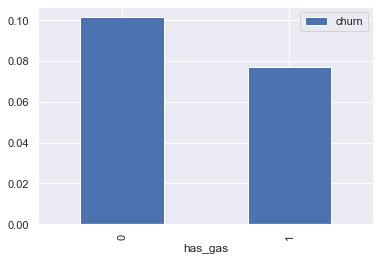

In [23]:
pco_energydata.groupby(['has_gas']).agg({
    'churn' : 'mean'
}).plot(kind='bar' )

<AxesSubplot:xlabel='churn'>

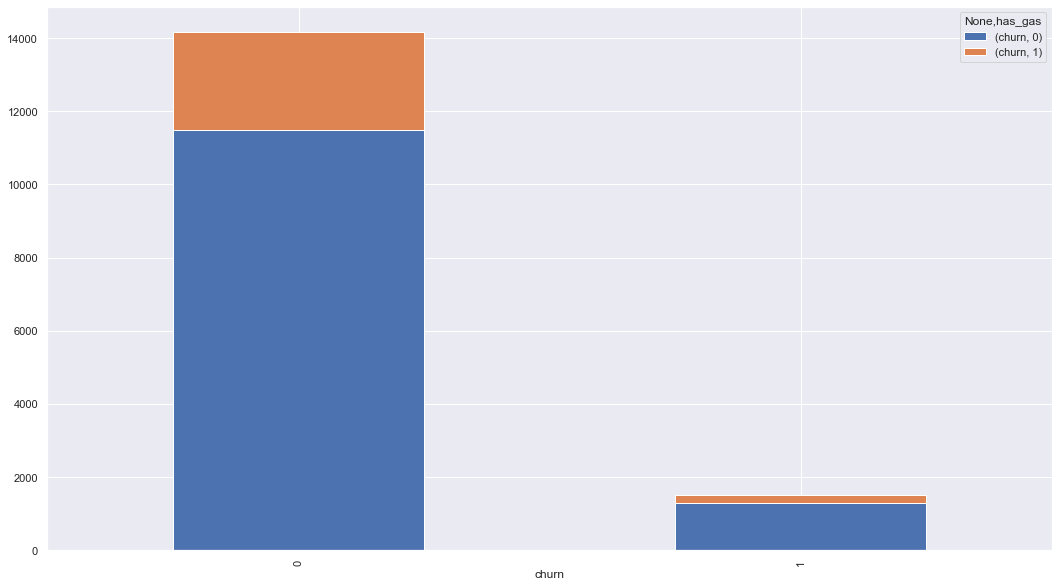

In [24]:
# Print the graph of their count
gas_data = pco_energydata.groupby(['churn' , 'has_gas']).agg({
    'churn' : 'count'
}).unstack(level=1)

gas_data.plot(kind='bar' ,stacked=True, figsize=(18,10))

There are less subscribed to gas the customers who churn, they are only 2% 

### Transforming categorical data
Using technique called `one-hot encoding`

<AxesSubplot:>

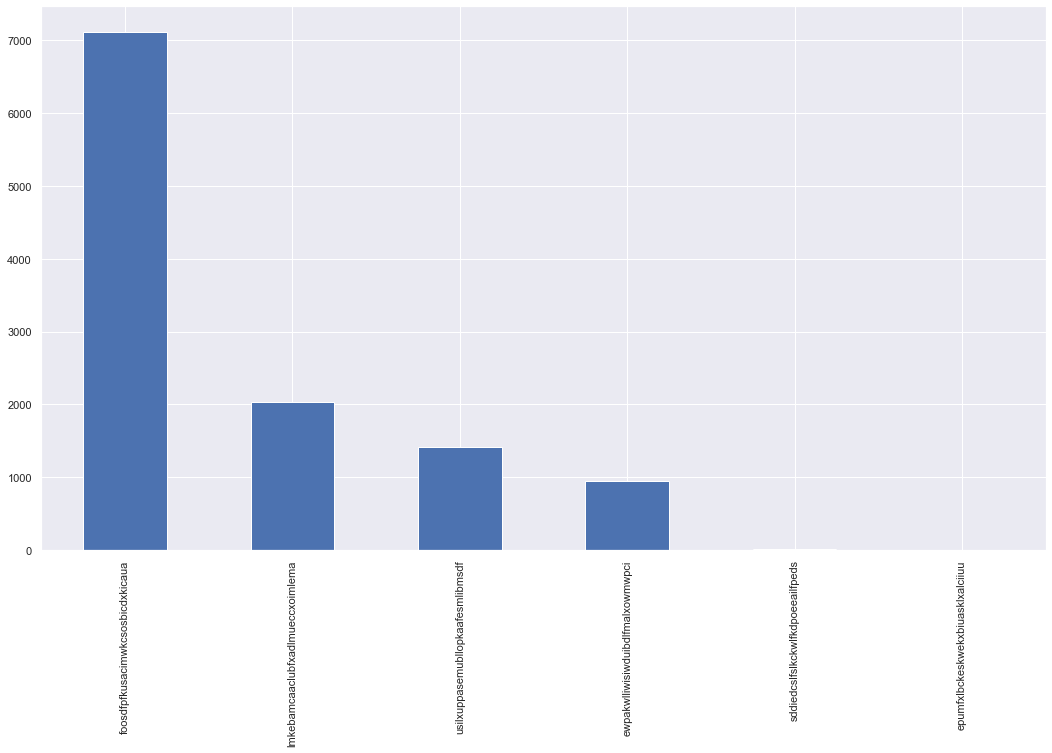

In [25]:
pco_energydata['channel_sales'] = pco_energydata['channel_sales'].astype('category')

pco_energydata['channel_sales'].value_counts().plot(kind='bar' , figsize=(18,10))

The last 2 is nearly 0, so we arw gonna drop them. These dummy variables will be almost entirely 0 and so will not add much predictive power to the model at all (since they're almost entirely a constant value and provide very little).

For this reason, we will drop these 3 dummy variables.

In [26]:
pco_energydata = pd.get_dummies(pco_energydata, columns=['channel_sales'], prefix='channel')
pco_energydata = pco_energydata.drop(columns=['channel_sddiedcslfslkckwlfkdpoeeailfpeds', 'channel_epumfxlbckeskwekxbiuasklxalciiuu'])
pco_energydata.head()

,id,forecast_discount_energy,forecast_price_energy_p1,forecast_price_energy_p2,forecast_price_pow_p1,has_gas,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,origin_up,pow_max,churn,mean_year_price_p1_var,mean_year_price_p2_var,mean_year_price_p3_var,mean_year_price_p1_fix,mean_year_price_p2_fix,mean_year_price_p3_fix,mean_year_price_p1,mean_year_price_p2,mean_year_price_p3,mean_6m_price_p1_var,mean_6m_price_p2_var,mean_6m_price_p3_var,mean_6m_price_p1_fix,mean_6m_price_p2_fix,mean_6m_price_p3_fix,mean_6m_price_p1,mean_6m_price_p2,mean_6m_price_p3,mean_3m_price_p1_var,mean_3m_price_p2_var,mean_3m_price_p3_var,mean_3m_price_p1_fix,mean_3m_price_p2_fix,mean_3m_price_p3_fix,mean_3m_price_p1,mean_3m_price_p2,mean_3m_price_p3,log_cons_12m,log_cons_gas_12m,log_cons_last_month,log_forecast_cons_12m,log_forecast_cons_year,log_forecast_meter_rent_12m,log_imp_cons,p1_diff_dec_jan_energy,p1_diff_dec_power,p1_p2_mean_diff,p2_p3_mean_diff,p1_p3_mean_diff,p1_p2_mean_diff,p2_p3_mean_diff,p1_p3_mean_diff,p1_p2_max_monthly_diff,p2_p3_max_monthly_diff,p1_p3_max_monthly_diff,p1_p2_fix_max_monthly_diff,p2_p3_fix_max_monthly_diff,p1_p3_fix_max_monthly_diff,tenure,time_since_months_activ,time_since_months_to_end,time_since_months_modif_prod,time_since_months_renewal,channel_ewpakwlliwisiwduibdlfmalxowmwpci,channel_foosdfpfkusacimwkcsosbicdxkicaua,channel_lmkebamcaaclubfxadlmueccxoimlema,channel_usilxuppasemubllopkaafesmlibmsdf
0,48ada52261e7cf58715202705a0451c9,0.0,0.095919,0.088347,58.995952,0,41.76,41.76,1,1732.36,3,ldkssxwpmemidmecebumciepifcamkci,180.000,0,0.103449,0.092115,0.067241,58.956502,36.356887,8.337051,59.059950,36.449002,8.404292,0.100854,0.090756,0.067104,58.976228,36.369049,8.339841,59.077082,36.459805,8.406945,0.099169,0.089992,0.066557,59.055124,36.417705,8.350997,59.154293,36.507697,8.417554,12.641989,0.0,9.212937,10.185703,9.212937,5.886909,6.724794,-0.007952,0.236694,22.599614,28.019836,50.619451,22.599614,28.019836,50.619451,0.012569,0.026096,0.038665,59.083843,28.122958,50.805737,3,37,10,37,1,0,0,1,0
1,d29c2c54acc38ff3c0614d0a653813dd,0.0,0.145711,0.000000,44.311378,0,16.38,16.38,1,18.89,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.800,0,0.149682,0.000000,0.000000,44.311375,0.000000,0.000000,44.461057,0.000000,0.000000,0.147996,0.000000,0.000000,44.355820,0.000000,0.000000,44.503816,0.000000,0.000000,0.147600,0.000000,0.000000,44.444710,0.000000,0.000000,44.592310,0.000000,0.000000,8.446985,0.0,0.000000,5.252012,0.000000,2.848971,0.000000,-0.003767,0.177779,44.311375,0.000000,44.311375,44.311375,0.000000,44.311375,0.151367,0.000000,0.151367,44.444710,0.000000,44.444710,7,76,7,76,4,0,0,0,0
2,764c75f661154dac3a6c254cd082ea7d,0.0,0.165794,0.087899,44.311378,0,28.60,28.60,1,6.60,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.856,0,0.170512,0.088421,0.000000,44.385450,0.000000,0.000000,44.555962,0.088421,0.000000,0.168569,0.088535,0.000000,44.444710,0.000000,0.000000,44.613279,0.088535,0.000000,0.167798,0.088409,0.000000,44.444710,0.000000,0.000000,44.612508,0.088409,0.000000,6.300786,0.0,0.000000,3.891004,0.000000,3.681855,0.000000,-0.004670,0.177779,44.385450,0.000000,44.385450,44.385450,0.000000,44.385450,0.084587,0.089162,0.172468,44.356301,0.000000,44.444710,6,68,3,68,8,0,1,0,0
3,bba03439a292a1e166f80264c16191cb,0.0,0.146694,0.000000,44.311378,0,30.22,30.22,1,25.46,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.200,0,0.151210,0.000000,0.000000,44.400265,0.000000,0.000000,44.551475,0.000000,0.000000,0.149330,0.000000,0.000000,44.444710,0.000000,0.000000,44.594040,0.000000,0.000000,0.148586,0.000000,0.000000,44.444710,0.000000,0.000000,44.593296,0.000000,0.000000,7.368340,0.0,0.000000,5.484963,0.000000,3.036394,0.000000,-0.004547,0.177779,44.400265,0.000000,44.400265,44.400265,0.000000,44.400265,0.153133,0.000000,0.153133,44.444710,0.000000,44.444710,6,69,2,69,9,0,0,1,0
4,568bb38a1afd7c0fc49c77b3789b59a3,0.0,0.110083,0.093746,40.606701,0,3.18,3.18,1,823.18,6,lxidpiddsbxsbosboudacockeimpuepw,75.000,0,0.118448,0.098134,0.069

### origin_up

In [27]:
# Transform into categorical type
pco_energydata['origin_up'] = pco_energydata['origin_up'].astype('category')

# Let's see how many categories are within this column
pco_energydata['origin_up'].value_counts()

lxidpiddsbxsbosboudacockeimpuepw    7589
kamkkxfxxuwbdslkwifmmcsiusiuosws    4489
ldkssxwpmemidmecebumciepifcamkci    3592
usapbepcfoloekilkwsdiboslwaxobdp       2
ewxeelcelemmiwuafmddpobolfuxioce       1
Name: origin_up, dtype: int64

In [28]:
pco_energydata = pd.get_dummies(pco_energydata, columns=['origin_up'], prefix='origin_up')
pco_energydata = pco_energydata.drop(columns=['origin_up_usapbepcfoloekilkwsdiboslwaxobdp', 'origin_up_ewxeelcelemmiwuafmddpobolfuxioce'])
pco_energydata.head()

,id,forecast_discount_energy,forecast_price_energy_p1,forecast_price_energy_p2,forecast_price_pow_p1,has_gas,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,pow_max,churn,mean_year_price_p1_var,mean_year_price_p2_var,mean_year_price_p3_var,mean_year_price_p1_fix,mean_year_price_p2_fix,mean_year_price_p3_fix,mean_year_price_p1,mean_year_price_p2,mean_year_price_p3,mean_6m_price_p1_var,mean_6m_price_p2_var,mean_6m_price_p3_var,mean_6m_price_p1_fix,mean_6m_price_p2_fix,mean_6m_price_p3_fix,mean_6m_price_p1,mean_6m_price_p2,mean_6m_price_p3,mean_3m_price_p1_var,mean_3m_price_p2_var,mean_3m_price_p3_var,mean_3m_price_p1_fix,mean_3m_price_p2_fix,mean_3m_price_p3_fix,mean_3m_price_p1,mean_3m_price_p2,mean_3m_price_p3,log_cons_12m,log_cons_gas_12m,log_cons_last_month,log_forecast_cons_12m,log_forecast_cons_year,log_forecast_meter_rent_12m,log_imp_cons,p1_diff_dec_jan_energy,p1_diff_dec_power,p1_p2_mean_diff,p2_p3_mean_diff,p1_p3_mean_diff,p1_p2_mean_diff,p2_p3_mean_diff,p1_p3_mean_diff,p1_p2_max_monthly_diff,p2_p3_max_monthly_diff,p1_p3_max_monthly_diff,p1_p2_fix_max_monthly_diff,p2_p3_fix_max_monthly_diff,p1_p3_fix_max_monthly_diff,tenure,time_since_months_activ,time_since_months_to_end,time_since_months_modif_prod,time_since_months_renewal,channel_ewpakwlliwisiwduibdlfmalxowmwpci,channel_foosdfpfkusacimwkcsosbicdxkicaua,channel_lmkebamcaaclubfxadlmueccxoimlema,channel_usilxuppasemubllopkaafesmlibmsdf,origin_up_kamkkxfxxuwbdslkwifmmcsiusiuosws,origin_up_ldkssxwpmemidmecebumciepifcamkci,origin_up_lxidpiddsbxsbosboudacockeimpuepw
0,48ada52261e7cf58715202705a0451c9,0.0,0.095919,0.088347,58.995952,0,41.76,41.76,1,1732.36,3,180.000,0,0.103449,0.092115,0.067241,58.956502,36.356887,8.337051,59.059950,36.449002,8.404292,0.100854,0.090756,0.067104,58.976228,36.369049,8.339841,59.077082,36.459805,8.406945,0.099169,0.089992,0.066557,59.055124,36.417705,8.350997,59.154293,36.507697,8.417554,12.641989,0.0,9.212937,10.185703,9.212937,5.886909,6.724794,-0.007952,0.236694,22.599614,28.019836,50.619451,22.599614,28.019836,50.619451,0.012569,0.026096,0.038665,59.083843,28.122958,50.805737,3,37,10,37,1,0,0,1,0,0,1,0
1,d29c2c54acc38ff3c0614d0a653813dd,0.0,0.145711,0.000000,44.311378,0,16.38,16.38,1,18.89,6,13.800,0,0.149682,0.000000,0.000000,44.311375,0.000000,0.000000,44.461057,0.000000,0.000000,0.147996,0.000000,0.000000,44.355820,0.000000,0.000000,44.503816,0.000000,0.000000,0.147600,0.000000,0.000000,44.444710,0.000000,0.000000,44.592310,0.000000,0.000000,8.446985,0.0,0.000000,5.252012,0.000000,2.848971,0.000000,-0.003767,0.177779,44.311375,0.000000,44.311375,44.311375,0.000000,44.311375,0.151367,0.000000,0.151367,44.444710,0.000000,44.444710,7,76,7,76,4,0,0,0,0,1,0,0
2,764c75f661154dac3a6c254cd082ea7d,0.0,0.165794,0.087899,44.311378,0,28.60,28.60,1,6.60,6,13.856,0,0.170512,0.088421,0.000000,44.385450,0.000000,0.000000,44.555962,0.088421,0.000000,0.168569,0.088535,0.000000,44.444710,0.000000,0.000000,44.613279,0.088535,0.000000,0.167798,0.088409,0.000000,44.444710,0.000000,0.000000,44.612508,0.088409,0.000000,6.300786,0.0,0.000000,3.891004,0.000000,3.681855,0.000000,-0.004670,0.177779,44.385450,0.000000,44.385450,44.385450,0.000000,44.385450,0.084587,0.089162,0.172468,44.356301,0.000000,44.444710,6,68,3,68,8,0,1,0,0,1,0,0
3,bba03439a292a1e166f80264c16191cb,0.0,0.146694,0.000000,44.311378,0,30.22,30.22,1,25.46,6,13.200,0,0.151210,0.000000,0.000000,44.400265,0.000000,0.000000,44.551475,0.000000,0.000000,0.149330,0.000000,0.000000,44.444710,0.000000,0.000000,44.594040,0.000000,0.000000,0.148586,0.000000,0.000000,44.444710,0.000000,0.000000,44.593296,0.000000,0.000000,7.368340,0.0,0.000000,5.484963,0.000000,3.036394,0.000000,-0.004547,0.177779,44.400265,0.000000,44.400265,44.400265,0.000000,44.400265,0.153133,0.000000,0.153133,44.444710,0.000000,44.444710,6,69,2,69,9,0,0,1,0,1,0,0
4,568bb38a1afd7c0fc49c77b3789b59a3,0.0,0.110083,0.093746,40.606701,0,3.18,3.18,1,823.18,6,75.000,0,0.118448,0.098134,0.069168,40.674580,24.40474

<AxesSubplot:xlabel='log_forecast_meter_rent_12m', ylabel='Density'>

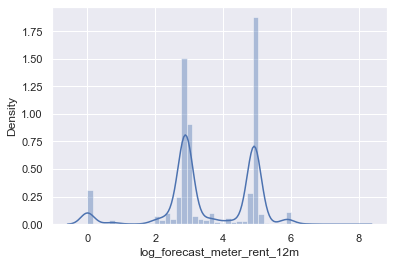

In [29]:

sns.distplot(pco_energydata['log_forecast_meter_rent_12m'])


### Distributions of some of these features

We have transform the features in the previous task, let's look at the distribution more closely.

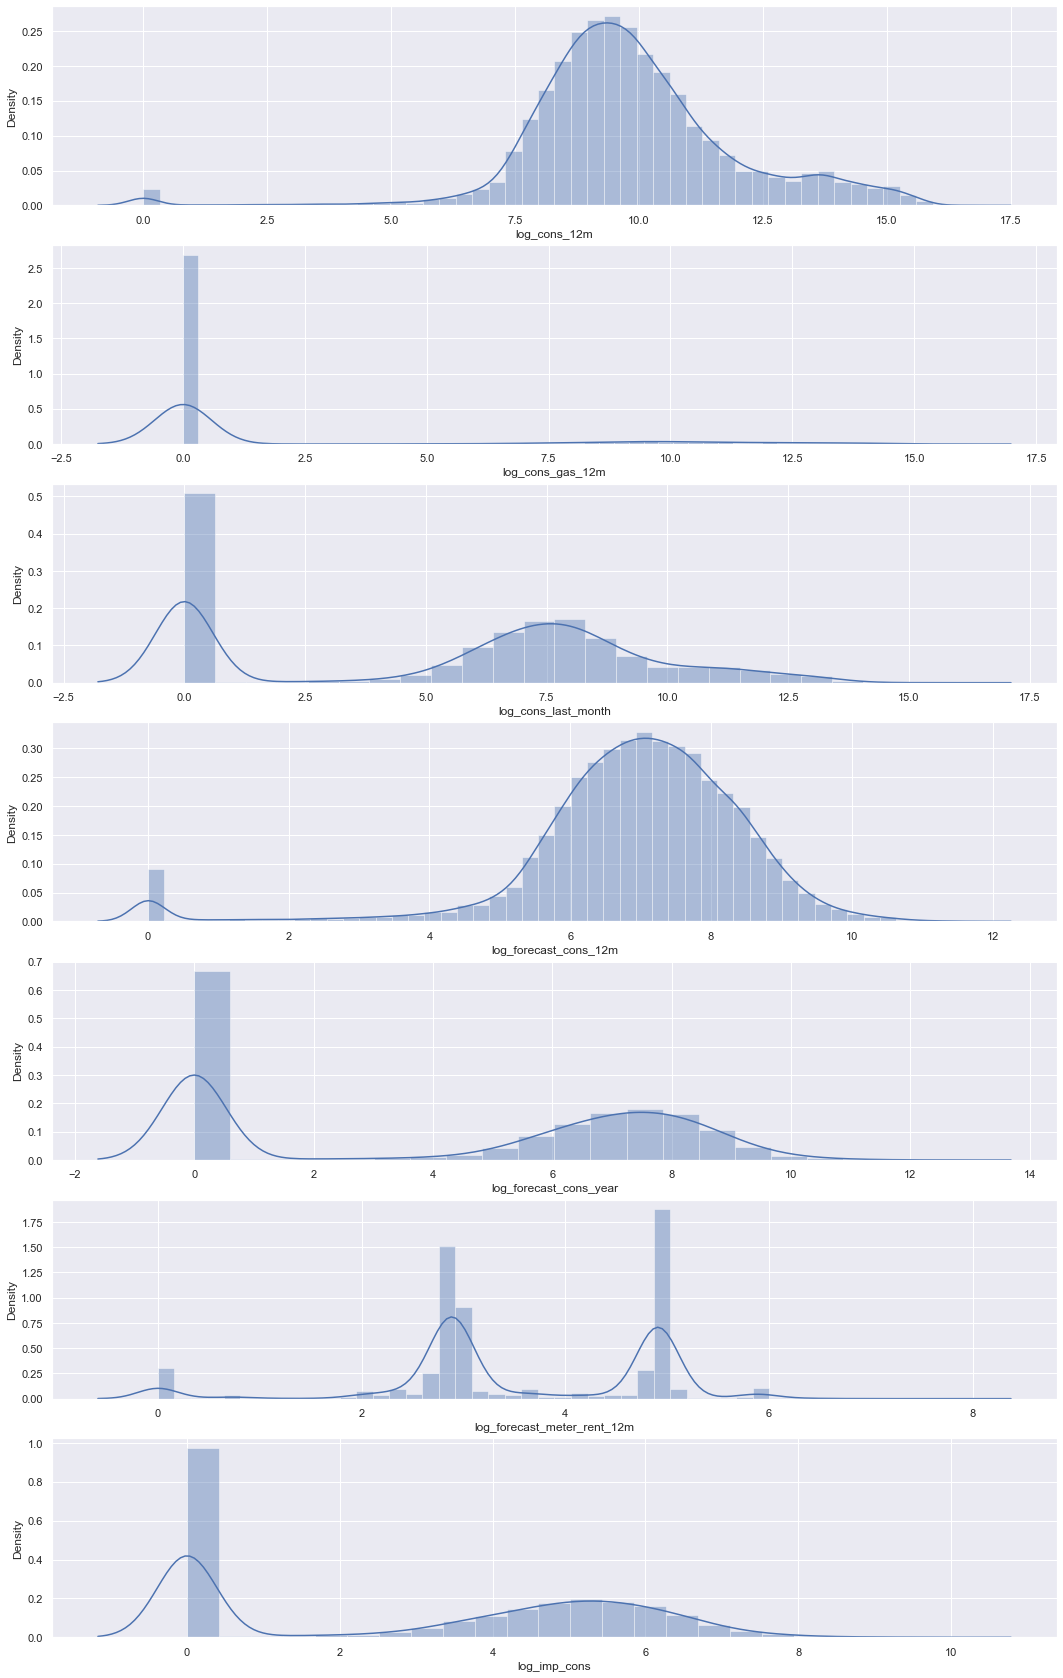

In [30]:
columns = ['log_cons_12m', 'log_cons_gas_12m', 'log_cons_last_month',
       'log_forecast_cons_12m', 'log_forecast_cons_year',
       'log_forecast_meter_rent_12m', 'log_imp_cons']

# defining the parameters
fig , axs = plt.subplots(nrows=len(columns) , figsize = (18,30))
count = 0
for cols in columns:
    sns.distplot(pco_energydata[cols] , ax=axs[count])
    count += 1
plt.show()

# sns.distplot(pco_energydata['log_cons_12m'] , ax=axs[0])


In [31]:
[cols for cols in pco_energydata if cols.startswith(("mean" , "log" , "peak" , "time" , "channel" , "origin" , "off_peak"))]


['mean_year_price_p1_var',
 'mean_year_price_p2_var',
 'mean_year_price_p3_var',
 'mean_year_price_p1_fix',
 'mean_year_price_p2_fix',
 'mean_year_price_p3_fix',
 'mean_year_price_p1',
 'mean_year_price_p2',
 'mean_year_price_p3',
 'mean_6m_price_p1_var',
 'mean_6m_price_p2_var',
 'mean_6m_price_p3_var',
 'mean_6m_price_p1_fix',
 'mean_6m_price_p2_fix',
 'mean_6m_price_p3_fix',
 'mean_6m_price_p1',
 'mean_6m_price_p2',
 'mean_6m_price_p3',
 'mean_3m_price_p1_var',
 'mean_3m_price_p2_var',
 'mean_3m_price_p3_var',
 'mean_3m_price_p1_fix',
 'mean_3m_price_p2_fix',
 'mean_3m_price_p3_fix',
 'mean_3m_price_p1',
 'mean_3m_price_p2',
 'mean_3m_price_p3',
 'log_cons_12m',
 'log_cons_gas_12m',
 'log_cons_last_month',
 'log_forecast_cons_12m',
 'log_forecast_cons_year',
 'log_forecast_meter_rent_12m',
 'log_imp_cons',
 'time_since_months_activ',
 'time_since_months_to_end',
 'time_since_months_modif_prod',
 'time_since_months_renewal',
 'channel_ewpakwlliwisiwduibdlfmalxowmwpci',
 'channel_foos

## Check the correlation between the features

This is important because it reveals the linear relationships between features. We want features to correlate with churn, as this will indicate that they are good predictors of it. However features that have a very high correlation can sometimes be suspicious. If the 2 features have the correlation, they probably gives the similar information. <br>
Features must have a correlation with the depedant variables which is the target variable

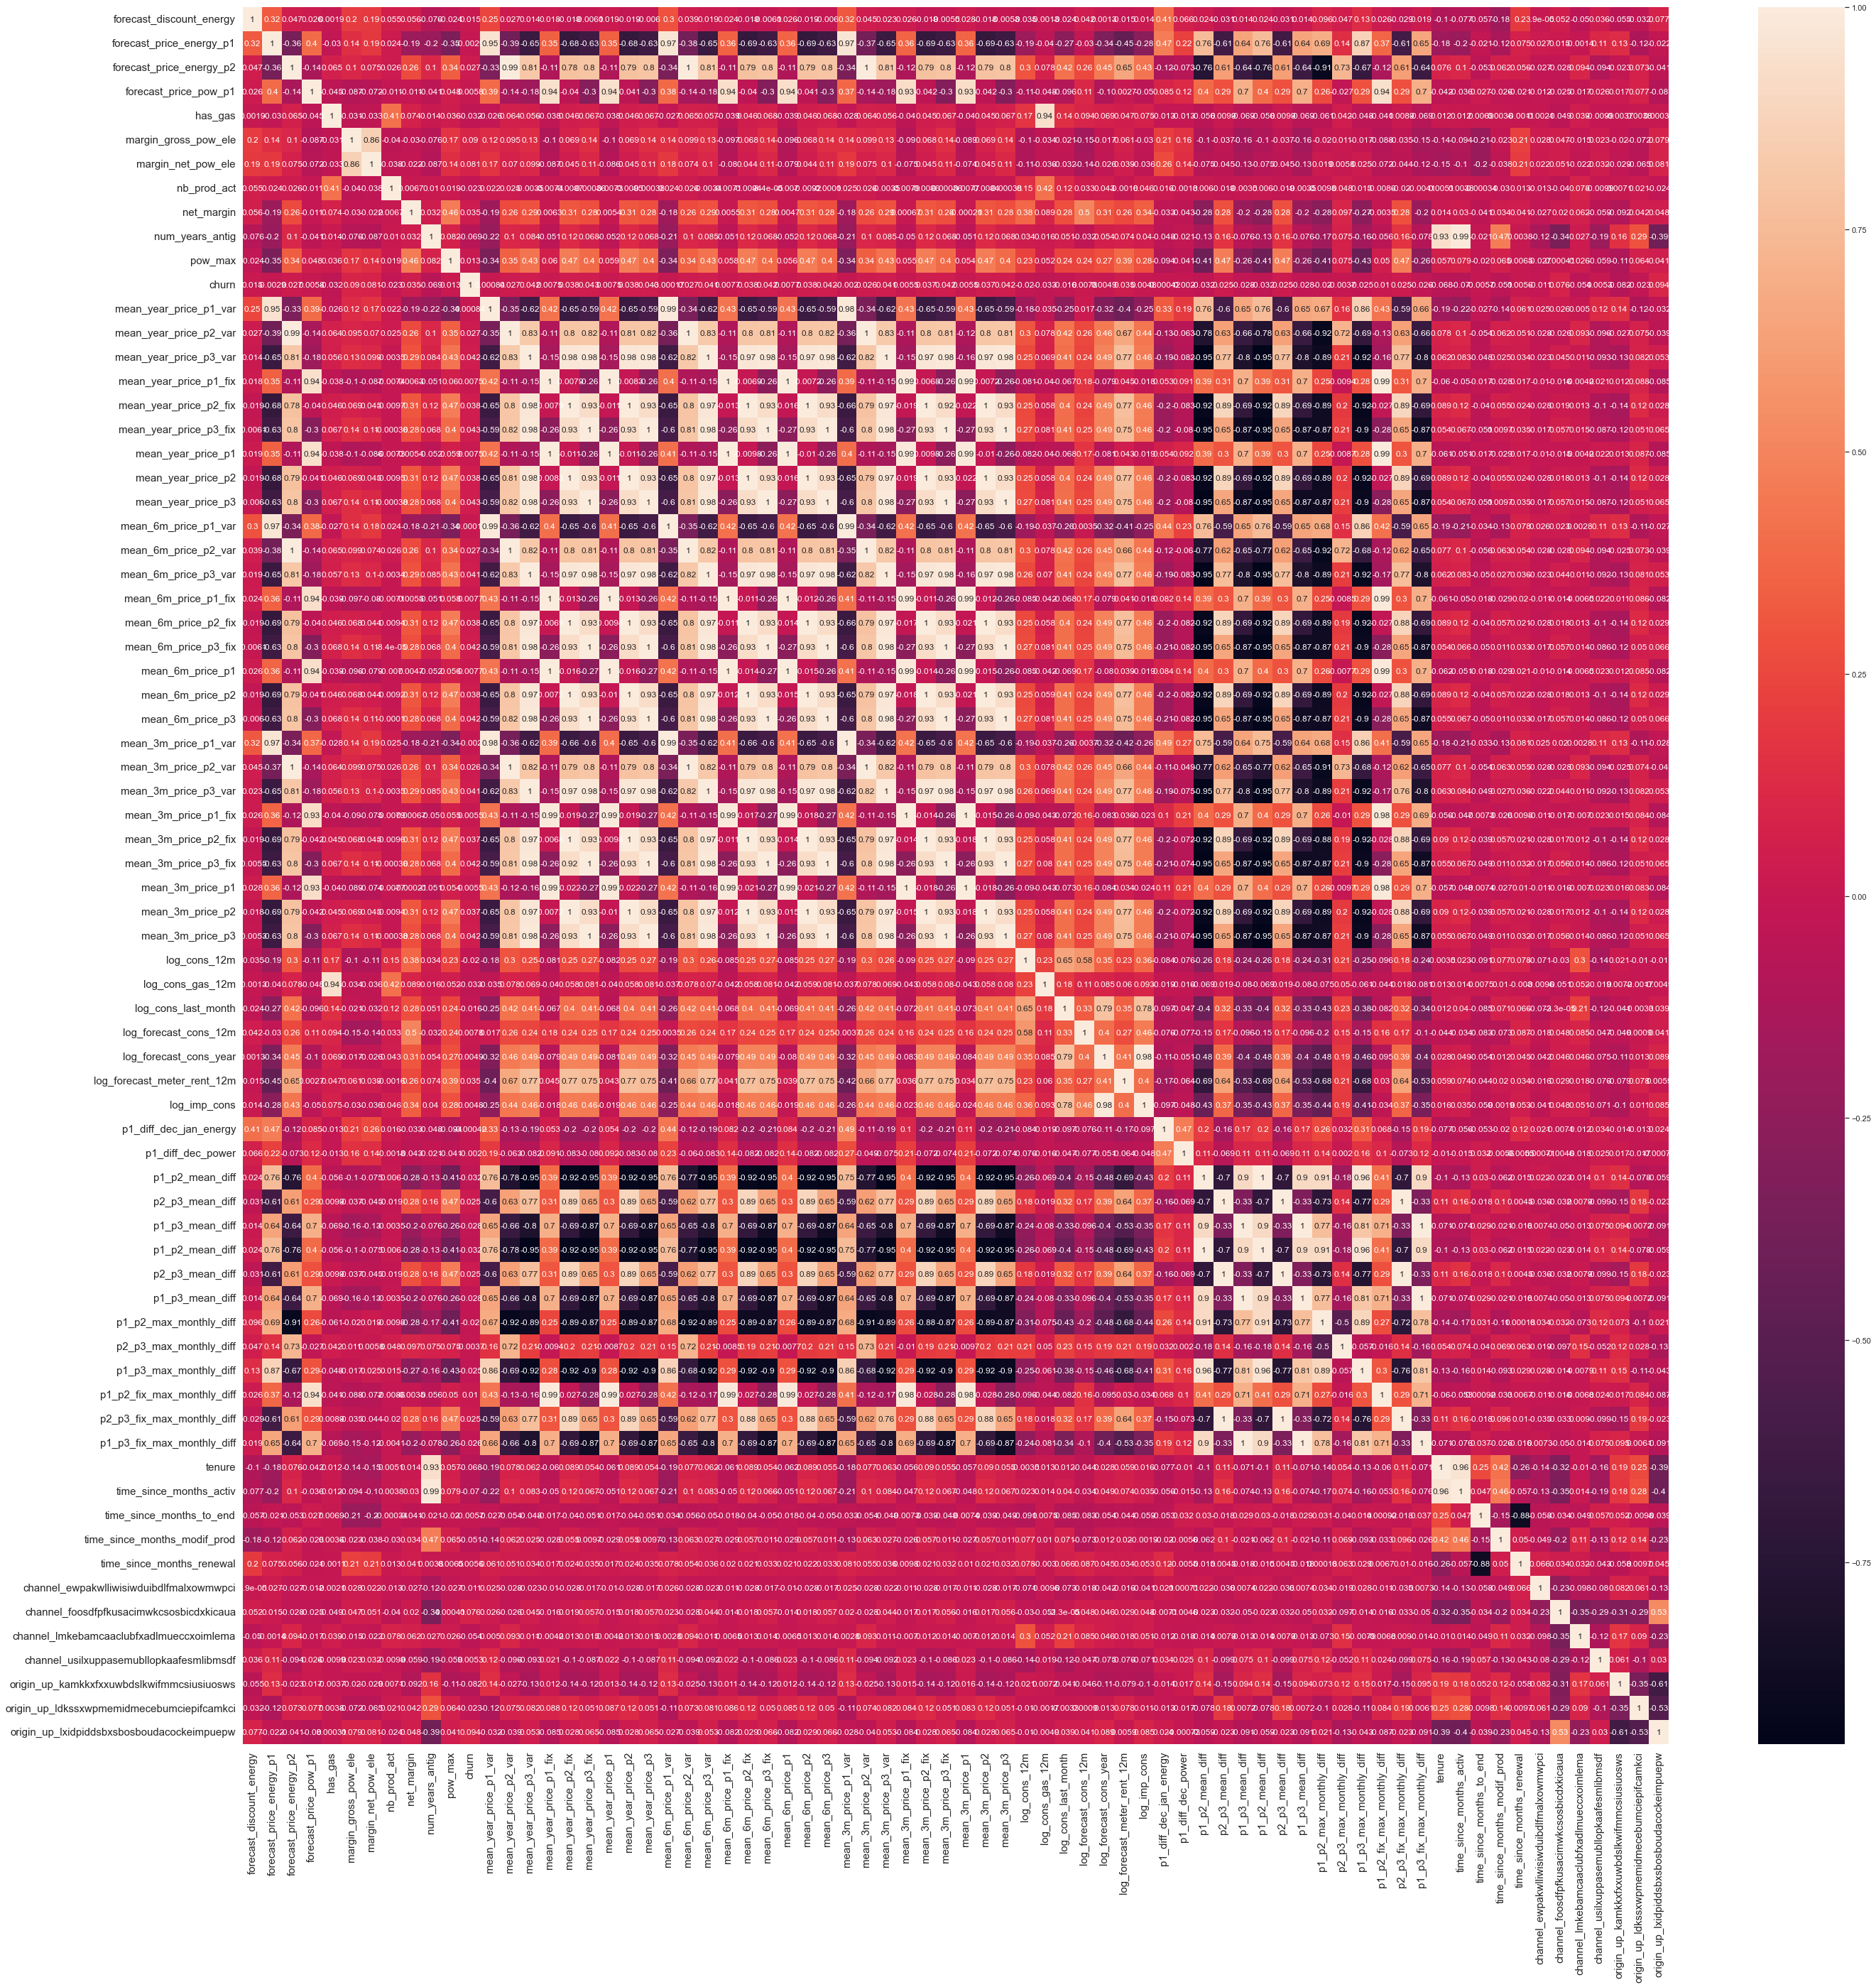

In [32]:
# these are the features that we created
# columns = [cols for cols in pco_energydata if cols.startswith(("mean" , "log" , "peak" , "time" , "channel" , "origin" , "off_peak" , "churn" , "forcast" , "num"))]
correlations = pco_energydata.corr()

# plot the correlations
plt.figure(figsize=(45,45))
sns.heatmap(
    correlations,
    xticklabels = correlations.columns.values,
    yticklabels = correlations.columns.values,
    annot = True,
    annot_kws = {'size' : 12}
)

plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.show()

In [33]:
# I feel like there are 3 features that are inter correlated, and removing these 2 features
pco_energydata.drop(
    columns = ['log_forecast_meter_rent_12m' , 'log_imp_cons' , 'num_years_antig' 
              ,'has_gas' , 'p1_p3_fix_max_monthly_diff']
    , inplace=True)

# Modeling
We will use the `Random Forest` classifier to train the model

In [34]:
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier

In [35]:
y = pco_energydata['churn']
x = pco_energydata.drop(columns=['id' , 'churn'])

print(y.shape)
print(x.shape)

(15673,)
(15673, 66)


In [36]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(11754, 66)
(11754,)
(3919, 66)
(3919,)


Instead of relying on 1 single decision tree for prediction, the random forest puts it to the overall views of the entire collection of decision trees. Some ensemble algorithms using a voting approach to decide which prediction is best, others using averaging.

As we increase the number of learners, the idea is that the random forest's performance should converge to its best possible solution.

The random forest uses a rule-based approach instead of a distance calculation and so features do not need to be scaled
It is able to handle non-linear parameters better than linear based models.

In [37]:
model = RandomForestClassifier(
    n_estimators = 1000)
model.fit(X_train , y_train)

RandomForestClassifier(n_estimators=1000)

### Evaluation
Now let's evaluate how well this trained model is able to predict the values of the test dataset.

We are going to use 3 metrics to evaluate performance:

Accuracy = the ratio of correctly predicted observations to the total observations
Precision = the ability of the classifier to not label a negative sample as positive
Recall = the ability of the classifier to find all the positive samples

In [38]:
predictions = model.predict(X_test)
tn, fp, fn, tp = metrics.confusion_matrix(y_test, predictions).ravel()

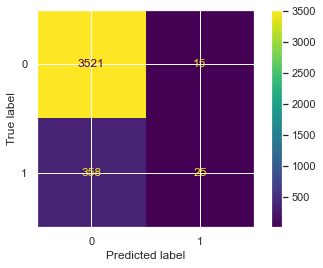

In [39]:
plot_confusion_matrix(model, X_test, y_test)  
plt.show()

In [40]:
print(f"True positives: {tp}")
print(f"False positives: {fp}")
print(f"True negatives: {tn}")
print(f"False negatives: {fn}\n")

print(f"Accuracy: {metrics.accuracy_score(y_test, predictions)}")
print(f"Precision: {metrics.precision_score(y_test, predictions)}")
print(f"Recall: {metrics.recall_score(y_test, predictions)}")

True positives: 25
False positives: 15
True negatives: 3521
False negatives: 358

Accuracy: 0.9048226588415412
Precision: 0.625
Recall: 0.06527415143603134


In [41]:
y_test.reset_index().groupby(['churn']).count()



,index
churn,
0,3536
1,383


### End Analysis
* total test cases = 3919
* churn = 0 3519 / 3536 -> this is good
* churn = 1 25 / 383 -> this is quite high, this should be addres, it should be close to 0
* False negative = 358, it means the we have predicted a client not churn, but in actually they did churn and we predicted the wrong.
* False Positibe = 17, this is less and this is good. It shows that we have predicted client has churn, but in actual they didn't
* Looking at only accuracy, this is very misleading, hence the use of precision and recall is very important
* So overall, we're able to very accurately identify clients that do not churn, but we are not able to predict cases where clients do churn! What we are seeing is that a high % of clients are being identified as not churning when they should be identified as churning. This in turn tells me that the current set of features are not discriminative enough to clearly distinguish between churners and non-churners.

### Model understanding
A simple way of understanding the results of a model is to look at feature importances. Feature importances indicate the importance of a feature within the predictive model

In [42]:
feature_importance = pd.DataFrame({
    'features' : X_train.columns,
    'importance' : model.feature_importances_
}).sort_values(by='importance' , ascending=True).reset_index()

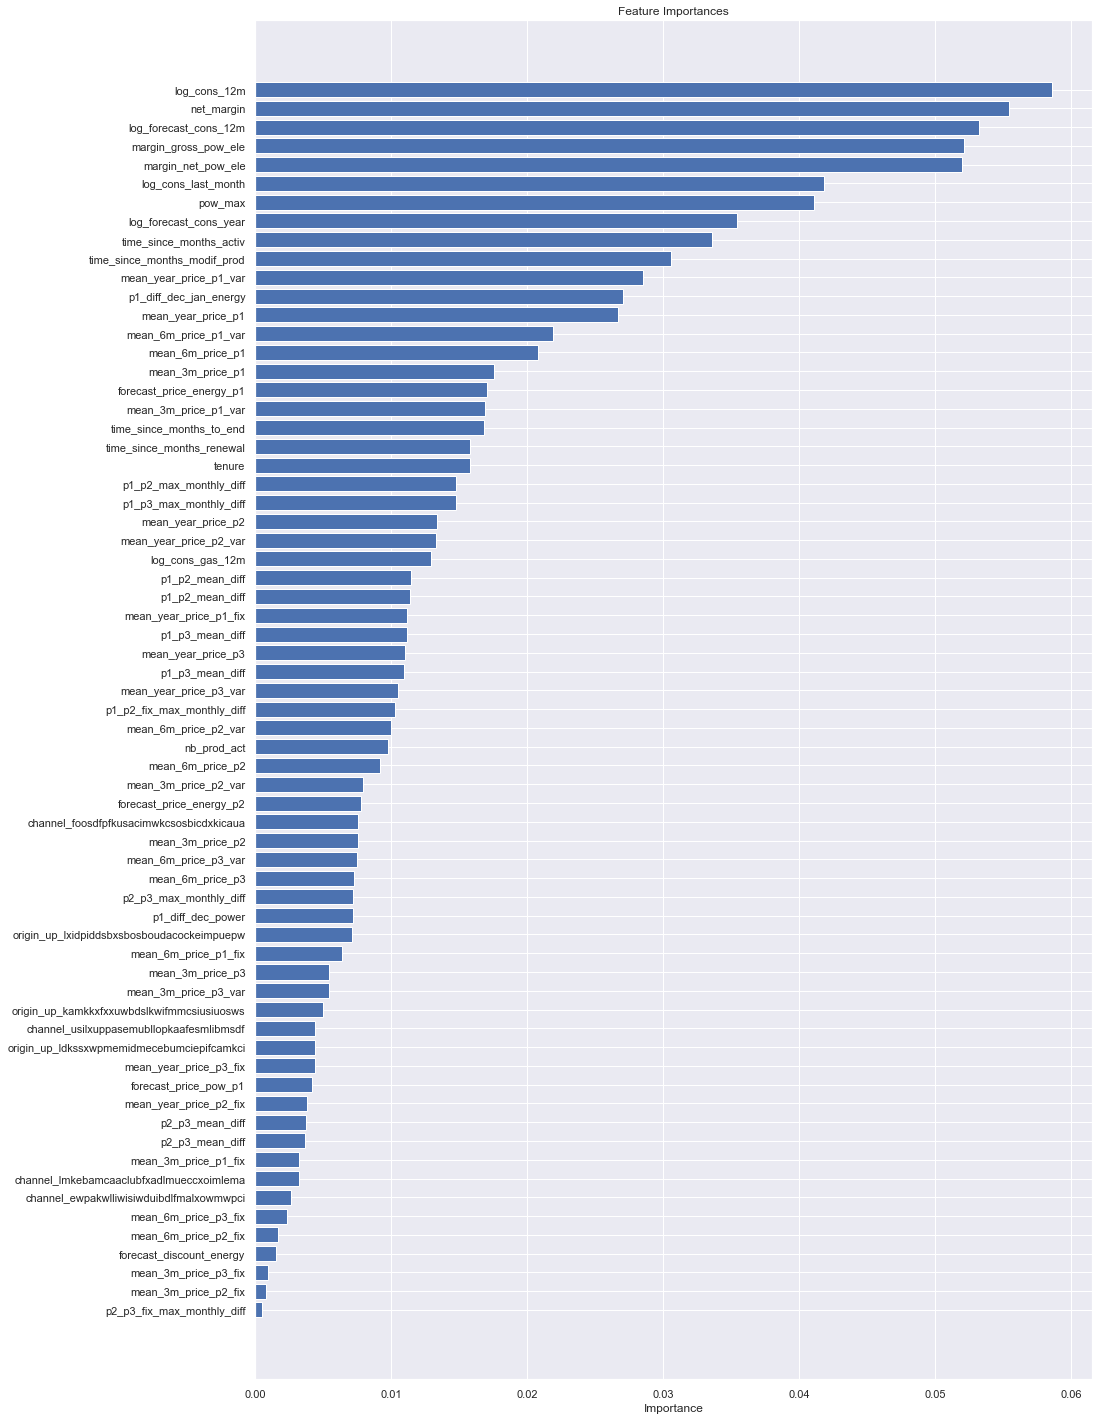

In [43]:
plt.figure(figsize=(15, 25))
plt.title('Feature Importances')
plt.barh(range(len(feature_importance)), feature_importance['importance'], color='b', align='center')
plt.yticks(range(len(feature_importance)), feature_importance['features'])
plt.xlabel('Importance')
plt.show()

### Perform Furthur Improvement in the model
1) I'll remove the outliers agains with zscore and IQR <br>
2) I'll create the parameterized hypertuned model (Next Notebook)
---

In [44]:
def replaceOutlier_zscore(dataframe , column , z=3):
    
    from scipy.stats import zscore
    
    """
    Steps to follow
    """
    df = dataframe
    
    # Step 1: Calculate mean with zscore
    df.dropna(inplace = True, subset=[column])
    df['zscore'] = zscore(df[column])
    mean_value = df[(df['zscore'] > -z) & (df['zscore'] < z)][column].mean()
    
    # Step 2: replace NA with mean, calcuate zscore again
    #         and replace outliers with the mean value 
    dataframe[column] = dataframe[column].fillna(mean_value)
    dataframe["zscore"] = zscore(dataframe[column])
    outliers = dataframe[(dataframe["zscore"] < -z) | (dataframe["zscore"] > z)].shape[0]
    dataframe.loc[(dataframe["zscore"] < -z) | (dataframe["zscore"] > z) , column] = mean_value
    
    print("Replaced: " , outliers , "Column: " , column)
    return dataframe.drop(columns="zscore")

def find_outliers_iqr(dataframe, column): 
 
    """
    With the values of the iqr, lower_bound and upper_bound
    """
    
    col = sorted(dataframe[column])
    q1, q3= np.percentile(col,[25,75]) 
    iqr = q3 - q1
    
    lower_bound = q1 -(1.5 * iqr) 
    upper_bound = q3 +(1.5 * iqr)

    results = {"iqr": iqr, "lower_bound":lower_bound, "upper_bound":upper_bound}
    
    return results

def remove_outliers_iqr(dataframe, column): 

    outliers = find_outliers_iqr(dataframe, column)

    removed = dataframe[(dataframe[column] < outliers["lower_bound"]) | 
                        (dataframe[column] > outliers["upper_bound"])].shape

    dataframe = dataframe[(dataframe[column] > outliers["lower_bound"]) &
                          (dataframe[column] < outliers["upper_bound"])] 
    
    print("Removed:", removed[0], " outliers")
    
    return dataframe
    

In [78]:
pco_test

,id,forecast_discount_energy,forecast_price_energy_p1,forecast_price_energy_p2,forecast_price_pow_p1,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,pow_max,churn,mean_year_price_p1_var,mean_year_price_p2_var,mean_year_price_p3_var,mean_year_price_p1_fix,mean_year_price_p2_fix,mean_year_price_p3_fix,mean_year_price_p1,mean_year_price_p2,mean_year_price_p3,mean_6m_price_p1_var,mean_6m_price_p2_var,mean_6m_price_p3_var,mean_6m_price_p1_fix,mean_6m_price_p2_fix,mean_6m_price_p3_fix,mean_6m_price_p1,mean_6m_price_p2,mean_6m_price_p3,mean_3m_price_p1_var,mean_3m_price_p2_var,mean_3m_price_p3_var,mean_3m_price_p1_fix,mean_3m_price_p2_fix,mean_3m_price_p3_fix,mean_3m_price_p1,mean_3m_price_p2,mean_3m_price_p3,log_cons_12m,log_cons_gas_12m,log_cons_last_month,log_forecast_cons_12m,log_forecast_cons_year,p1_diff_dec_jan_energy,p1_diff_dec_power,p2_p3_mean_diff,p1_p3_mean_diff,p2_p3_mean_diff,p1_p3_mean_diff,p1_p2_max_monthly_diff,p2_p3_max_monthly_diff,p1_p3_max_monthly_diff,p1_p2_fix_max_monthly_diff,p2_p3_fix_max_monthly_diff,tenure,time_since_months_activ,time_since_months_to_end,time_since_months_modif_prod,time_since_months_renewal,channel_ewpakwlliwisiwduibdlfmalxowmwpci,channel_foosdfpfkusacimwkcsosbicdxkicaua,channel_lmkebamcaaclubfxadlmueccxoimlema,channel_usilxuppasemubllopkaafesmlibmsdf,origin_up_kamkkxfxxuwbdslkwifmmcsiusiuosws,origin_up_ldkssxwpmemidmecebumciepifcamkci,origin_up_lxidpiddsbxsbosboudacockeimpuepw,zscore
0,48ada52261e7cf58715202705a0451c9,0.0,0.095919,0.088347,58.995952,41.76,41.76,1,1732.36,180.000,0,0.103449,0.092115,0.067241,58.956502,36.356887,8.337051,59.059950,36.449002,8.404292,0.100854,0.090756,0.067104,58.976228,36.369049,8.339841,59.077082,36.459805,8.406945,0.099169,0.089992,0.066557,59.055124,36.417705,8.350997,59.154293,36.507697,8.417554,12.641989,0.000000,9.212937,10.185703,9.212937,-0.007952,0.236694,28.019836,50.619451,28.019836,50.619451,0.012569,0.026096,0.038665,59.083843,28.122958,3,37,10,37,1,0,0,1,0,0,1,0,-2.007614
1,d29c2c54acc38ff3c0614d0a653813dd,0.0,0.145711,0.000000,44.311378,16.38,16.38,1,18.89,13.800,0,0.149682,0.000000,0.000000,44.311375,0.000000,0.000000,44.461057,0.000000,0.000000,0.147996,0.000000,0.000000,44.355820,0.000000,0.000000,44.503816,0.000000,0.000000,0.147600,0.000000,0.000000,44.444710,0.000000,0.000000,44.592310,0.000000,0.000000,8.446985,0.000000,0.000000,5.252012,0.000000,-0.003767,0.177779,0.000000,44.311375,0.000000,44.311375,0.151367,0.000000,0.151367,44.444710,0.000000,7,76,7,76,4,0,0,0,0,1,0,0,0.568613
2,764c75f661154dac3a6c254cd082ea7d,0.0,0.165794,0.087899,44.311378,28.60,28.60,1,6.60,13.856,0,0.170512,0.088421,0.000000,44.385450,0.000000,0.000000,44.555962,0.088421,0.000000,0.168569,0.088535,0.000000,44.444710,0.000000,0.000000,44.613279,0.088535,0.000000,0.167798,0.088409,0.000000,44.444710,0.000000,0.000000,44.612508,0.088409,0.000000,6.300786,0.000000,0.000000,3.891004,0.000000,-0.004670,0.177779,0.000000,44.385450,0.000000,44.385450,0.084587,0.089162,0.172468,44.356301,0.000000,6,68,3,68,8,0,1,0,0,1,0,0,1.607703
3,bba03439a292a1e166f80264c16191cb,0.0,0.146694,0.000000,44.311378,30.22,30.22,1,25.46,13.200,0,0.151210,0.000000,0.000000,44.400265,0.000000,0.000000,44.551475,0.000000,0.000000,0.149330,0.000000,0.000000,44.444710,0.000000,0.000000,44.594040,0.000000,0.000000,0.148586,0.000000,0.000000,44.444710,0.000000,0.000000,44.593296,0.000000,0.000000,7.368340,0.000000,0.000000,5.484963,0.000000,-0.004547,0.177779,0.000000,44.400265,0.000000,44.400265,0.153133,0.000000,0.153133,44.444710,0.000000,6,69,2,69,9,0,0,1,0,1,0,0,0.619473
4,568bb38a1afd7c0fc49c77b3789b59a3,0.0,0.110083,0.093746,40.606701,3.18,3.18,1,823.18,75.000,0,0.118448,0.098134,0.069168,40.674580,24.404747,16.269833,40.793027,24.502881,16.339001,0.114428,0.096080,0.069418,40.728885,24.437330,16.291555,40.843313,24.533410,16.360973,0.113068,0.095385,0.069409,40.728885,24.437330,16.291555,40.841953,24.532715,16.360964,11.706319,0.000000,9.425532,9.293396,9.425532,-0.010018,

In [94]:
pco_test = pco_energydata
pco_energydata.churn.value_counts()

0    14153
1     1520
Name: churn, dtype: int64

In [95]:
# columns = [cols for cols in pco_energydata.columns if cols.startswith("mean")]
columns = ['id' , 'forecast_discount_energy' , 'net_margin' , 'churn' , 'p2_p3_mean_diff' , 
           'p1_p3_mean_diff' , 'p1_p2_mean_diff' , 'zscore']

for col in pco_energydata.columns:
    if col not in columns:
        print(col)
        pco_energydata = replaceOutlier_zscore(pco_energydata , col )
        


forecast_price_energy_p1
Replaced:  0 Column:  forecast_price_energy_p1
forecast_price_energy_p2
Replaced:  0 Column:  forecast_price_energy_p2
forecast_price_pow_p1
Replaced:  156 Column:  forecast_price_pow_p1
margin_gross_pow_ele
Replaced:  234 Column:  margin_gross_pow_ele


<ipython-input-44-0a13294001a8>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace = True, subset=[column])


margin_net_pow_ele
Replaced:  223 Column:  margin_net_pow_ele
nb_prod_act
Replaced:  60 Column:  nb_prod_act
pow_max
Replaced:  287 Column:  pow_max
mean_year_price_p1_var
Replaced:  268 Column:  mean_year_price_p1_var
mean_year_price_p2_var
Replaced:  0 Column:  mean_year_price_p2_var
mean_year_price_p3_var
Replaced:  0 Column:  mean_year_price_p3_var
mean_year_price_p1_fix
Replaced:  117 Column:  mean_year_price_p1_fix
mean_year_price_p2_fix
Replaced:  0 Column:  mean_year_price_p2_fix
mean_year_price_p3_fix
Replaced:  0 Column:  mean_year_price_p3_fix
mean_year_price_p1
Replaced:  135 Column:  mean_year_price_p1
mean_year_price_p2
Replaced:  0 Column:  mean_year_price_p2
mean_year_price_p3
Replaced:  0 Column:  mean_year_price_p3
mean_6m_price_p1_var
Replaced:  289 Column:  mean_6m_price_p1_var
mean_6m_price_p2_var
Replaced:  0 Column:  mean_6m_price_p2_var
mean_6m_price_p3_var
Replaced:  0 Column:  mean_6m_price_p3_var
mean_6m_price_p1_fix
Replaced:  132 Column:  mean_6m_price_p1_f

In [96]:
pco_energydata.churn.value_counts()

0    14153
1     1520
Name: churn, dtype: int64

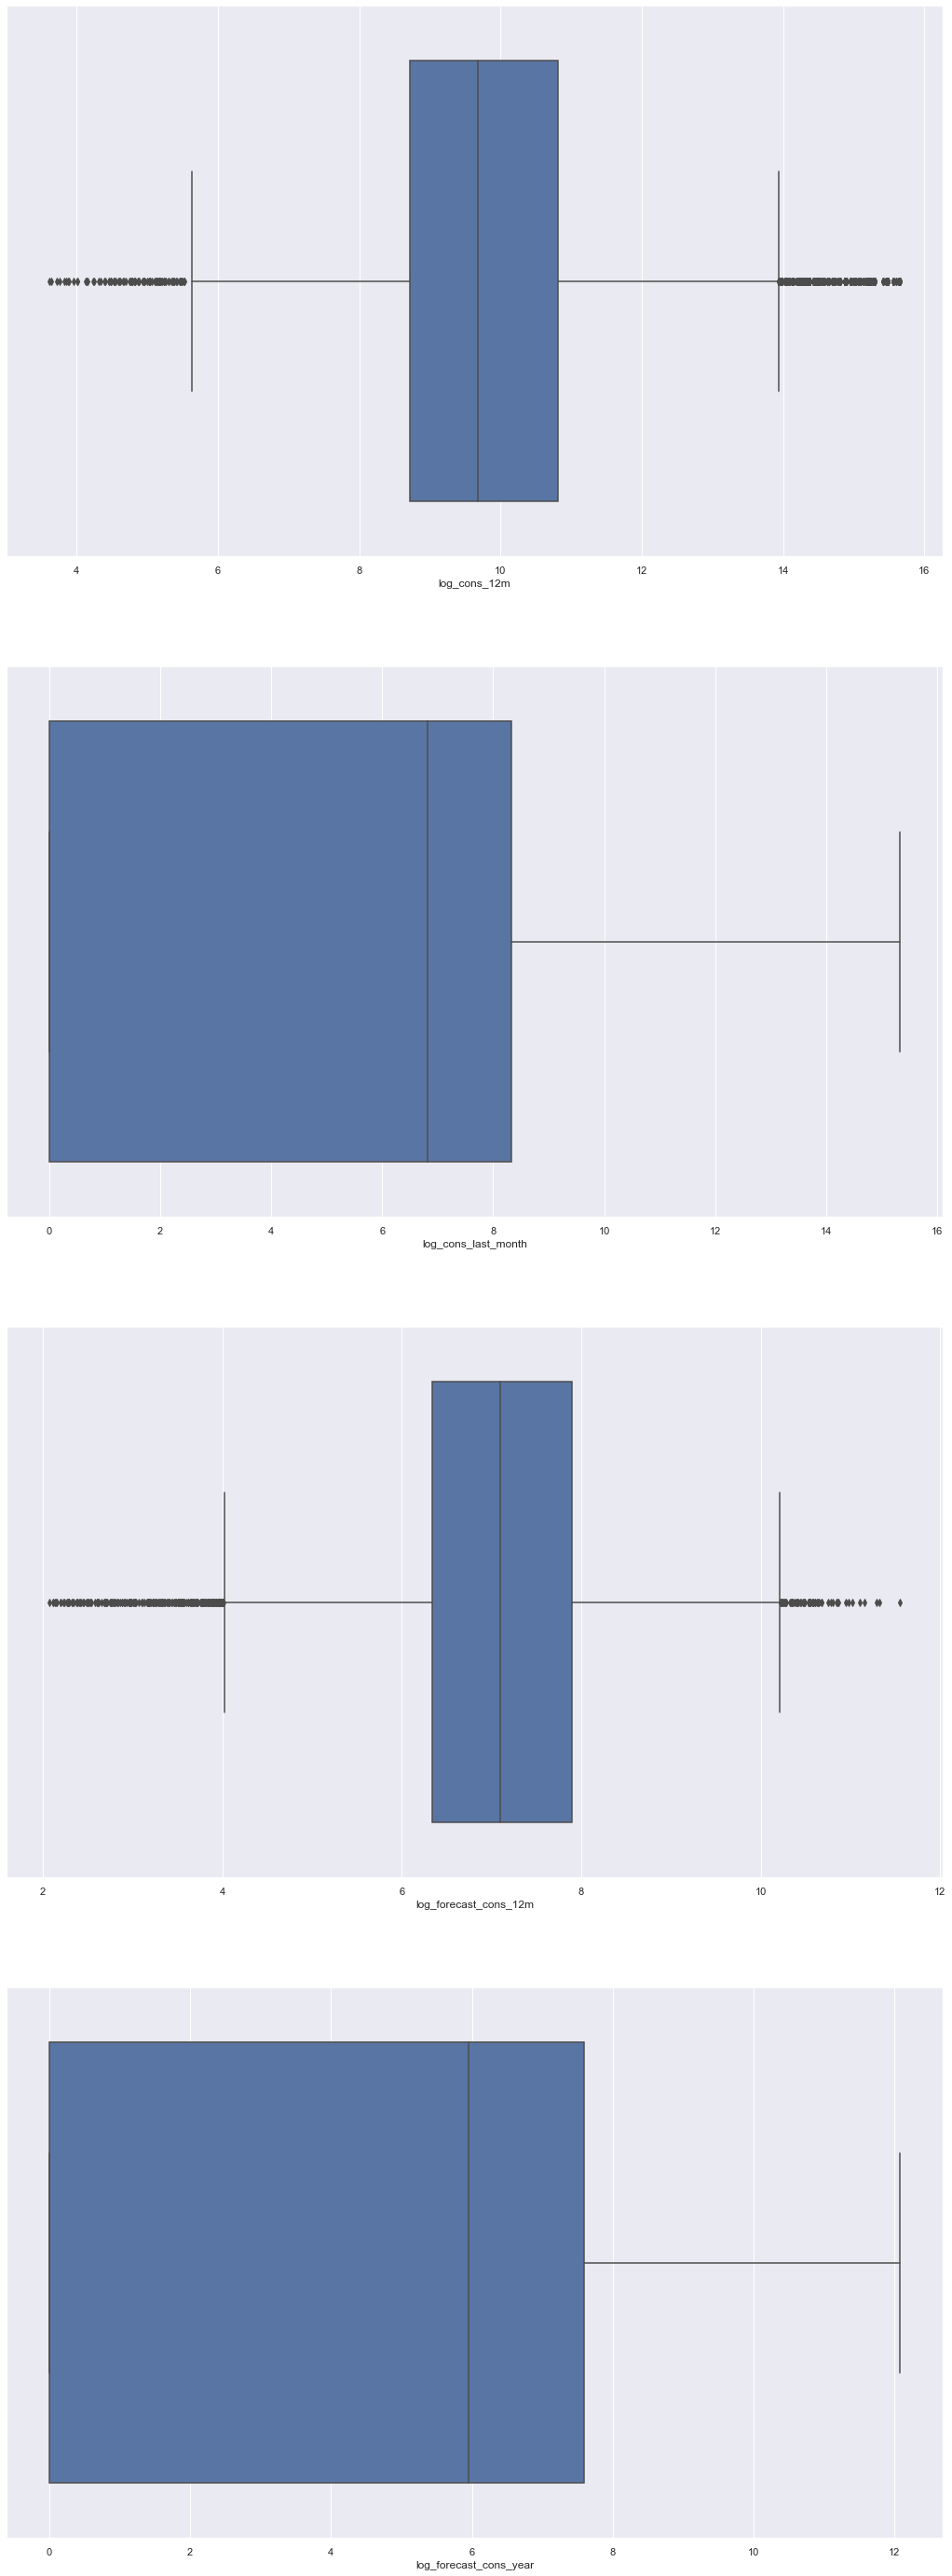

In [97]:
fig, axs = plt.subplots(nrows=4, figsize=(18,50))
# Plot boxplots
sns.boxplot((pco_energydata["log_cons_12m"].dropna()), ax=axs[0])
sns.boxplot((pco_energydata["log_cons_last_month"].dropna()), ax=axs[1])
sns.boxplot((pco_energydata["log_forecast_cons_12m"].dropna()), ax=axs[2]) 
sns.boxplot((pco_energydata["log_forecast_cons_year"].dropna()), ax=axs[3])
plt.show()


### Save the Pickle file

In [98]:
PICKLE_DIR = os.path.join("processed_data", "processed_V2_EnergyData.pkl")
pd.to_pickle(pco_energydata, PICKLE_DIR)

Interesting to Note:
* Multicollinearity happens when one predictor variable in a multiple regression model can be linearly predicted from the others with a high degree of accuracy. This can lead to skewed or misleading results. Luckily, decision trees and boosted trees algorithms are immune to multicollinearity by nature. When they decide to split, the tree will choose only one of the perfectly correlated features. However, other algorithms like Logistic Regression or Linear Regression are not immune to that problem and should be ﬁxed before training the model.